<a href="https://colab.research.google.com/github/vivorima/Span-ASTE/blob/main/SPAN_ASTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Texte VMI 23/24
Implémentation de la méthode :

[Learning Span-Level Interactions for Aspect Sentiment Triplet Extraction](https://aclanthology.org/2021.acl-long.367) (Xu et al., ACL-IJCNLP 2021)

**Groupe:**

Yidhir Aghiles KOULAL, Rima MAHMOUDI & Shangyu YAO

Ce modèle nommé **Span-ASTE** vise à adresser les limitations des approches existantes en considérant les interactions entre les cibles et les opinions pour la tâche Aspect Sentiment Triplet Extraction (ASTE).

Il utilise une approche de niveau de span qui prend en compte les interactions de l'ensemble des cibles et d'opinions pour prédire leur relation de sentiment.

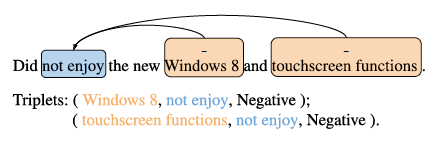



#Architechture:
 Le modèle Span-ASTE se compose de trois modules principaux : **l'encodage de la phrase** (sentence encoding), **le module de mention** (mention module) et **le module de triplet** (triplet module).

  Pour commencer, la phrase est d'abord introduite dans le module d'encodage pour obtenir la représentation au niveau du jeton (token-level representation), à partir de laquelle nous dérivons la représentation au niveau de span pour chaque span énumérée.

  Note : On utilise une méthode d'encodage de phrase BiLSTM ou BERT pour obtenir les représentations contextualisées des mots, qui est essentielle pour capturer les nuances et les relations entre les mots dans le contexte de la phrase.

  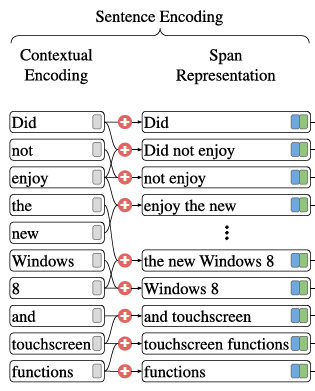
  
  Ensuite, nous adoptons les tâches ATE (**Aspect Term Extraction**) et OTE (**Opinion Term Extraction**) pour superviser notre stratégie de rognage à double canal (**dual-channel span pruning**), qui obtient les cibles rognées et les opinions candidates.
  
  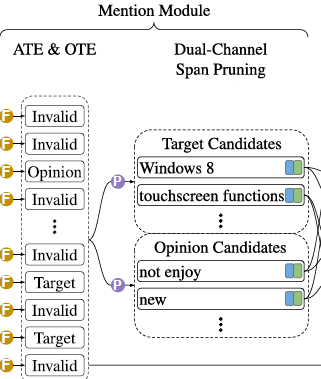

  Enfin, chaque cible candidate et opinion candidate sont couplées pour déterminer la relation de sentiment entre elles.

  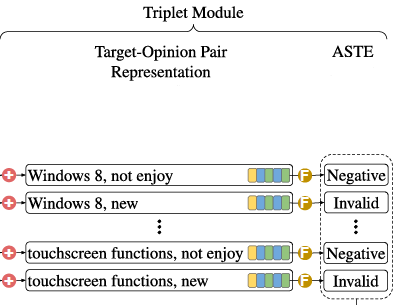

Le module de mention prend la représentation de chaque étendue énumérée comme entrée et prédit les types de mention m ∈ {Cible, Opinion, Invalide}. Le module de triplet obtient la représentation de la paire cible-opinion en couplant chaque représentation de cible candidate avec chaque représentation d'opinion candidate. Enfin, le modèle utilise une méthode d'encodage de phrase BiLSTM ou BERT pour obtenir les représentations contextualisées des mots dans une phrase.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/ProjetTEXTE_VMI_2024

/content/drive/MyDrive/ProjetTEXTE_VMI_2024


#Modèle Span-ASTE

Article : Learning Span-Level Interactions for Aspect Sentiment Triplet Extraction.

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import time
import torch
from torch import nn, Tensor
from torch.nn import LSTM, init
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
import argparse
import itertools
from functools import partial

from models.losses import log_likelihood
from models.metrics import SpanEvaluator
from models.collate import collate_fn, gold_labels
from utils.bar import ProgressBar
from utils.dataset import CustomDataset
from utils.processor import Res15DataProcessor
from utils.tager import SpanLabel, RelationLabel


##Représentation des spans

La représentation de span si,j dans l'ensemble S est définit comme suivant:

 Pour le modèle BiLSTM, la représentation si,j est formée par la concaténation des représentations de début, de fin et de largeur
 **$[hi; hj ; fwidth(i; j)]$**

 En revanche, pour le modèle BERT, la représentation si,j est formée par la concaténation des représentations de début, de fin et de largeur
 **$[xi; xj ; fwidth(i; j)]$**


In [ ]:
class SpanRepresentation(nn.Module):

    def __init__(self, span_width_embedding_dim, span_maximum_length):
        super(SpanRepresentation, self).__init__()
        self.span_maximum_length = span_maximum_length
        #les différentes plages de largeurs des span
        self.bucket_bins = [0, 1, 2, 3, 4, 5, 7, 8, 15, 16, 31, 32, 63, 64]
        self.span_width_embedding = nn.Embedding(len(self.bucket_bins), span_width_embedding_dim)

    #prend la largeur d'une span en paramètre et renvoie l'embedding(une représentation numérique dense de données)
    #Objectif : capturer les relations et les similarités entre les données
    def bucket_embedding(self, width, device):
        em = [ix for ix, v in enumerate(self.bucket_bins) if width >= v][-1]
        return self.span_width_embedding(torch.LongTensor([em]).to(device))


    #Créer des spans en concaténant les embeddings correspondants aux indices de début, fin et laregur des spans

    def forward(self, x: Tensor, batch_max_seq_len):

        batch_size, sequence_length, _ = x.size()
        device = x.device

        len_arrange = torch.arange(0, batch_max_seq_len, device=device)
        span_indices = []

        max_window = min(batch_max_seq_len, self.span_maximum_length)

        for window in range(1, max_window + 1):
            if window == 1:
                indics = [(x.item(), x.item()) for x in len_arrange]
            else:
                res = len_arrange.unfold(0, window, 1)
                indics = [(idx[0].item(), idx[-1].item()) for idx in res]
            span_indices.extend(indics)

        spans = [torch.cat(
            (x[:, s[0], :], x[:, s[1], :],
             self.bucket_embedding(abs(s[1] - s[0] + 1), device).repeat(
                 (batch_size, 1)).to(device)),
            dim=1) for s in span_indices]

        return torch.stack(spans, dim=1), span_indices

##Elagage des Spans (pruning)
Catégoriser les spans en "target" (cible) et "opinion" (opinion) ou bien "invalide" (invalid)

Une phrase x de longueur n aura $O(n^2)$ spans, soit $O(n^4)$ possibilités de paires de spans. Cela devient impraticable. ==> Stratégie d'élagage (Pruning Strategy)

In [ ]:
class PrunedTargetOpinion:

    def __init__(self):
        pass
    #nz est le nombre de spans à conserver après l'élagage
    def __call__(self, spans_probability, nz):
        #Sélectionner les indices des nz spans ayant les probabilités les plus élevées pour la catégorie "target"
        target_indices = torch.topk(spans_probability[:, :, SpanLabel.ASPECT.value], nz, dim=-1).indices
        #Sélectionner les indices des nz spans ayant les probabilités les plus élevées pour la catégorie "opinion"
        opinion_indices = torch.topk(spans_probability[:, :, SpanLabel.OPINION.value], nz, dim=-1).indices
        return target_indices, opinion_indices


In [ ]:
class TargetOpinionPairRepresentation(nn.Module):

    def __init__(self, distance_embeddings_dim):
        super(TargetOpinionPairRepresentation, self).__init__()
        self.bucket_bins = [0, 1, 2, 3, 4, 5, 7, 8, 15, 16, 31, 32, 63, 64]
        self.distance_embeddings = nn.Embedding(len(self.bucket_bins), distance_embeddings_dim)
    #(a et b) les indices de début et de fin des spans pour les cibles
    #(c et d) les indices de début et de fin des spans pour les opinions
    def min_distance(self, a, b, c, d):
        #la distance minimale entre les cibles et les opinions (5)
        return min(abs(b - c), abs(a - d))

    def bucket_embedding(self, width, device):
        em = [ix for ix, v in enumerate(self.bucket_bins) if width >= v][-1]
        return self.distance_embeddings(torch.LongTensor([em]).to(device))


    #Prend en entrée les représentations des spans
    #Génère des paires possibles de cibles et opinions, puis calcule les indices des spans correspondants à ces paires
    #Pour chaque paire, créer une représentation en concaténant les embeddings des spans
    #Retourne ces représentations pour la tâche d'apprentissage pour analyser les relations entre cibles et opinions
    def forward(self, spans, span_indices, target_indices, opinion_indices):

        batch_size = spans.size(0)
        device = spans.device
        candidate_indices, relation_indices = [], []
        for batch in range(batch_size):
            pairs = list(itertools.product(target_indices[batch].cpu().tolist(), opinion_indices[batch].cpu().tolist()))
            relation_indices.append(pairs)
            candidate_ind = []
            for pair in pairs:
                a, b = span_indices[pair[0]]
                c, d = span_indices[pair[1]]
                candidate_ind.append((a, b, c, d))
            candidate_indices.append(candidate_ind)

        candidate_pool = []
        for batch in range(batch_size):
            relations = [
                torch.cat((spans[batch, c[0], :], spans[batch, c[1], :],
                           self.bucket_embedding(
                               self.min_distance(*span_indices[c[0]], *span_indices[c[1]]), device).squeeze(0))
                          , dim=0) for c in
                relation_indices[batch]]
            candidate_pool.append(torch.stack(relations))

        return torch.stack(candidate_pool), candidate_indices, relation_indices


Le modèle Span ASTE developpé en PyTorch

In [ ]:
class SpanAsteModel(nn.Module):

    def __init__(
            self,
            pretrain_model,
            target_dim: "int",
            relation_dim: "int",
            ffnn_hidden_dim: "int" = 150,
            span_width_embedding_dim: "int" = 20,
            span_maximum_length: "int" = 8,
            span_pruned_threshold: "int" = 0.5,
            pair_distance_embeddings_dim: "int" = 128,
            device="cpu"
    ) -> None:

        super(SpanAsteModel, self).__init__()
        self.span_pruned_threshold = span_pruned_threshold
        self.pretrain_model = pretrain_model
        self.device = device

        # Initialisation du modèle BERT pré-entraîné
        self.bert = BertModel.from_pretrained(pretrain_model)
        encoding_dim = self.bert.config.hidden_size

        # Initialisation de la représentation des spans
        self.span_representation = SpanRepresentation(span_width_embedding_dim, span_maximum_length)
        span_dim = encoding_dim * 2 + span_width_embedding_dim

        # Réseau de neurones pour le pruning des spans
        self.span_ffnn = torch.nn.Sequential(
            nn.Linear(span_dim, ffnn_hidden_dim, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(ffnn_hidden_dim, ffnn_hidden_dim, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(ffnn_hidden_dim, target_dim, bias=True),
            nn.Softmax(-1)
        )

        # Module pour  les targets et opinions
        self.pruned_target_opinion = PrunedTargetOpinion()

        # Initialisation de la représentation des paires target-opinion
        self.target_opinion_pair_representation = TargetOpinionPairRepresentation(pair_distance_embeddings_dim)
        pairs_dim = 2 * span_dim + pair_distance_embeddings_dim

        # Réseau de neurones pour les paires target-opinion
        self.pairs_ffnn = torch.nn.Sequential(
            nn.Linear(pairs_dim, ffnn_hidden_dim, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(ffnn_hidden_dim, ffnn_hidden_dim, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(ffnn_hidden_dim, relation_dim, bias=True),
            nn.Softmax(-1)
        )

        # Initialisation des paramètres du modèle
        self.reset_parameters()

    def reset_parameters(self):
        # Initialisation des paramètres du réseau de neurones pour les spans
        for name, param in self.span_ffnn.named_parameters():
            if "weight" in name:
                init.xavier_normal_(param)
        # Initialisation des paramètres du réseau de neurones pour les paires target-opinion
        for name, param in self.pairs_ffnn.named_parameters():
            if "weight" in name:
                init.xavier_normal_(param)

    def forward(self, input_ids, attention_mask, token_type_ids, seq_len):

        batch_size, sequence_len = input_ids.size()
        batch_max_seq_len = max(seq_len)

        # Obtenir la sortie de BERT pour les embeddings de tokens
        bert_output = self.bert(input_ids, attention_mask, token_type_ids)
        x = bert_output.last_hidden_state

        # Obtention de la représentation des spans
        spans, span_indices = self.span_representation(x, batch_max_seq_len)

        # Passage à travers le réseau de neurones pour les spans
        spans_probability = self.span_ffnn(spans)

        # Calcul du seuil pour le prunning des spans(nz est le nombre de spans à conserver après l'élagage)
        nz = int(batch_max_seq_len * self.span_pruned_threshold)

        # Prunning des cibles et opinions
        target_indices, opinion_indices = self.pruned_target_opinion(spans_probability, nz)

        # Obtention des représentations des paires cible-opinion
        candidates, candidate_indices, relation_indices = self.target_opinion_pair_representation(spans, span_indices, target_indices, opinion_indices)

        # Passage à travers le réseau de neurones pour les paires cible-opinion
        candidate_probability = self.pairs_ffnn(candidates)

        # Indices des spans pour chaque batch
        span_indices = [span_indices for _ in range(batch_size)]

        # Retour des probabilités des spans, indices des spans, probabilités des paires, indices des candidats
        return spans_probability, span_indices, candidate_probability, candidate_indices


#Entrainement du Modèle

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


In [ ]:
def train_model(bert_model ,batch_size ,seed, learning_rate ,weight_decay ,warmup_proportion ,train_path ,dev_path ,save_dir ,max_seq_len ,num_epochs ,logging_steps , valid_steps):

    set_seed(seed)

    # Initialiser le tokenizer BERT
    tokenizer = BertTokenizer.from_pretrained(bert_model)
    processor = Res15DataProcessor(tokenizer, max_seq_len)

    print("Chargement des jeux de données d'entraînement et d'évaluation ==>")
    # Charger la dataset
    train_dataset = CustomDataset("train", train_path, processor, tokenizer, max_seq_len)
    eval_dataset = CustomDataset("dev", dev_path, processor, tokenizer, max_seq_len)

    print("Construction des DataLoaders ==>")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    print("Construction du modèle SPAN-ASTE ==>")
    # Obtention des dimensions pour les étiquettes de spans et de relations
    target_dim, relation_dim = len(SpanLabel), len(RelationLabel)
    # Construction du modèle
    model = SpanAsteModel(
        bert_model,
        target_dim,
        relation_dim,
        device=device
    )
    model.to(device)

    # Paramètres d'optimisation pour les différents groupes de paramètres du modèle
    no_decay = ['bias', 'LayerNorm.weight']
    bert_param_optimizer = list(model.bert.named_parameters())
    span_linear_param_optimizer = list(model.span_ffnn.named_parameters())
    pair_linear_param_optimizer = list(model.pairs_ffnn.named_parameters())
    optimizer_grouped_parameters = [
        {'params': [p for n, p in bert_param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay': weight_decay, 'lr': learning_rate},
        {'params': [p for n, p in bert_param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0,
         'lr': learning_rate},

        {'params': [p for n, p in span_linear_param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.0, 'lr': 1e-3},
        {'params': [p for n, p in span_linear_param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0,
         'lr': 1e-3},

        {'params': [p for n, p in pair_linear_param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.0, 'lr': 1e-3},
        {'params': [p for n, p in pair_linear_param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0,
         'lr': 1e-3}
    ]

    print("Construction de l'optimiseur ==>")
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate)
    num_training_steps = len(train_dataloader) * num_epochs
    num_warmup_steps = num_training_steps * warmup_proportion
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,
                                                num_training_steps=num_training_steps)

    metric = SpanEvaluator()

    tic_train = time.time()
    global_step = 0
    best_f1 = 0
    loss_list = []
    for epoch in range(1, num_epochs + 1):
        pbar = ProgressBar(n_total=len(train_dataloader), desc='Entraînement')
        model.train()
        for batch_ix, batch in enumerate(train_dataloader):
            input_ids, attention_mask, token_type_ids, spans, relations, span_labels, relation_labels, seq_len = batch
            input_ids = torch.tensor(input_ids, device=device)
            attention_mask = torch.tensor(attention_mask, device=device)
            token_type_ids = torch.tensor(token_type_ids, device=device)

            #Propagation avant(forward prop)
            spans_probability, span_indices, relations_probability, candidate_indices = model(
                input_ids, attention_mask, token_type_ids, seq_len)

            gold_span_indices, gold_span_labels = gold_labels(span_indices, spans, span_labels)
            loss_ner = log_likelihood(spans_probability, span_indices, gold_span_indices, gold_span_labels)

            gold_relation_indices, gold_relation_labels = gold_labels(candidate_indices, relations, relation_labels)
            loss_relation = log_likelihood(relations_probability, candidate_indices, gold_relation_indices,
                                           gold_relation_labels)

            #Calcul de la loss
            loss = 0.2 * loss_ner + loss_relation

            #Rétropropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            loss_list.append(float(loss))
            pbar(batch_ix, {"loss": float(loss)})
            print("")
            global_step += 1
            if global_step % logging_steps == 0:
                time_diff = time.time() - tic_train
                loss_avg = sum(loss_list) / len(loss_list)

                print("Étape globale %d, époque: %d, perte: %.5f" % (global_step, epoch, loss_avg))
                tic_train = time.time()

            #Validation
            if global_step % valid_steps == 0:
                precision, recall, f1 = evaluate(model, metric, eval_dataloader, device)
                print(
                    "Évaluation - Précision: %.5f, Rappel: %.5f, F1: %.5f" %
                    (precision, recall, f1))

                if f1 > best_f1:
                    print(
                        f"Meilleure performance F1 mise à jour : {best_f1:.5f} --> {f1:.5f}"
                    )
                    best_f1 = f1
                    save_dir = os.path.join(save_dir, "model_best")
                    if not os.path.exists(save_dir):
                        os.makedirs(save_dir)
                    torch.save(model.state_dict(), os.path.join(save_dir, "modelbst.pt"))

                tic_train = time.time()


##Exploration de la dataset

In [ ]:
import pandas as pd

train_path = "/content/drive/MyDrive/ProjetTEXTE_VMI_2024/data/15res/train_triplets.txt"

with open(train_path, "r", encoding="utf-8") as file:
    lines = file.readlines()
texts = []
spans = []

for line in lines:
    # Diviser le texte et les spans en utilisant le marqueur "####"
    parts = line.split("####")

    texts.append(parts[0].strip())

    # Ajouter les spans à la liste des spans
    span_info = eval(parts[1])
    spans.append(span_info)


df = pd.DataFrame({"Phrase": texts, "{[(target position, opinion position, sentiment)]}": spans})

# Afficher la structure du dataframe
print("Structure du dataframe :")
print(df.info())

print("=================================================================")

# Afficher les 10 premières lignes du dataframe
print("\nLes 10 premières lignes du dataframe :")
print(df.head(10))


Structure du dataframe :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   Phrase                                              605 non-null    object
 1   {[(target position, opinion position, sentiment)]}  605 non-null    object
dtypes: object(2)
memory usage: 9.6+ KB
None

Les 10 premières lignes du dataframe :
                                              Phrase  \
0  Judging from previous posts this used to be a ...   
1  We , there were four of us , arrived at noon -...   
2  The food was lousy - too sweet or too salty an...   
3                                 Avoid this place !   
4  I have eaten at Saul , many times , the food i...   
5  Saul is the best restaurant on Smith Street an...   
6  The duck confit is always amazing and the foie...   
7  The wine list i

###Entrainement
En utilisanat les meme parametres cités dans l'article (pg 4759)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print(f"Device:{device}")

train_model(bert_model = "bert-base-uncased",batch_size =1, seed = 1000, learning_rate=5e-5  ,weight_decay=1e-2 ,warmup_proportion=0.1 ,train_path="data/15res" ,dev_path="data/15res" ,save_dir="./checkpoint" ,max_seq_len=512 ,num_epochs=10 ,logging_steps=30 , valid_steps=50)


Device:cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Chargement des jeux de données d'entraînement et d'évaluation ==>
Construction des DataLoaders ==>
Construction du modèle SPAN-ASTE ==>


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Étape globale 1320, époque: 3, perte: 11.86280
[Entraînement] 111/605 [====>.........................] - ETA: 3:39  loss: 8.3006 
[Entraînement] 112/605 [====>.........................] - ETA: 3:38  loss: 5.0761 
[Entraînement] 113/605 [====>.........................] - ETA: 3:37  loss: 1.7151 
[Entraînement] 114/605 [====>.........................] - ETA: 3:35  loss: 0.7736 
[Entraînement] 115/605 [====>.........................] - ETA: 3:33  loss: 4.0442 
[Entraînement] 116/605 [====>.........................] - ETA: 3:32  loss: 3.3327 
[Entraînement] 117/605 [====>.........................] - ETA: 3:31  loss: 3.2654 
[Entraînement] 118/605 [====>.........................] - ETA: 3:30  loss: 2.0032 
[Entraînement] 119/605 [====>.........................] - ETA: 3:29  loss: 11.1301 
[Entraînement] 120/605 [====>.........................] - ETA: 3:27  loss: 8.4032 
[Entraînement] 121/605 [=====>..............

#Evaluation du modèle

In [ ]:
def evaluate(model, metric, data_loader, device):

    model.eval()
    metric.reset()

    with torch.no_grad():
        for batch_ix, batch in enumerate(data_loader):
            input_ids, attention_mask, token_type_ids, spans, relations, span_labels, relation_labels, seq_len = batch
            input_ids = torch.tensor(input_ids, device=device)
            attention_mask = torch.tensor(attention_mask, device=device)
            token_type_ids = torch.tensor(token_type_ids, device=device)

            spans_probability, span_indices, relations_probability, candidate_indices = model(input_ids, attention_mask, token_type_ids, seq_len)

            # Calcule les indices et label reelles
            gold_span_indices, gold_span_labels = gold_labels(span_indices, spans, span_labels)
            gold_relation_indices, gold_relation_labels = gold_labels(candidate_indices, relations, relation_labels)

            num_correct, num_infer, num_label = metric.compute(relations_probability.cpu(), torch.tensor(gold_relation_labels))
            metric.update(num_correct, num_infer, num_label)

    precision, recall, f1 = metric.accumulate()
    model.train()
    return precision, recall, f1

def model_evaluation(bert_model, batch_size, max_seq_len, model_path, test_path):

    # Initialise le seed pour la reproductibilité
    set_seed(1024)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print(f"Device : {device}")

    #le tokenizer BERT
    tokenizer = BertTokenizer.from_pretrained(bert_model)
    processor = Res15DataProcessor(tokenizer, max_seq_len)
    print("Chargement des jeux de données d'entraînement et d'évaluation ==>")

    test_dataset = CustomDataset("dev", test_path, processor, tokenizer, max_seq_len)

    print("Construction du DataLoader ==>")
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    print("Construction du modèle SPAN-ASTE ==>")
    target_dim, relation_dim = len(SpanLabel), len(RelationLabel)

    model = SpanAsteModel(
        bert_model,
        target_dim,
        relation_dim,
        device=device
    )
    model.load_state_dict(torch.load(os.path.join(model_path, "model.pt"), map_location=torch.device(device)))
    model.to(device)
    metric = SpanEvaluator()

    precision, recall, f1 = evaluate(model, metric, test_dataloader, device)
    print('\n\n')
    print("Évaluation ==> Précision : %.5f | Rappel : %.5f | Score F1 : %.5f" % (precision, recall, f1))


## Evaluation sur 15Res

In [ ]:
model_evaluation("bert-base-uncased",batch_size =1,max_seq_len=512,model_path='checkpoint/model_best',test_path='data/15res')

Device : cuda
Chargement des jeux de données d'entraînement et d'évaluation ==>
Construction du DataLoader ==>
Construction du modèle SPAN-ASTE ==>



Évaluation ==> Précision : 0.70614 | Rappel : 0.66805 | Score F1 : 0.68657


## Evaluation sur 14Res


In [ ]:
model_evaluation("bert-base-uncased",batch_size =1,max_seq_len=512,model_path='checkpoint/model_best',test_path='data/14res')

Device : cuda
Chargement des jeux de données d'entraînement et d'évaluation ==>
Construction du DataLoader ==>
Construction du modèle SPAN-ASTE ==>



Évaluation ==> Précision : 0.70549 | Rappel : 0.64329 | Score F1 : 0.67296


## Evaluation sur 16Res

In [ ]:
model_evaluation("bert-base-uncased",batch_size =1,max_seq_len=512,model_path='checkpoint/model_best',test_path='data/16res')

Device : cuda
Chargement des jeux de données d'entraînement et d'évaluation ==>
Construction du DataLoader ==>
Construction du modèle SPAN-ASTE ==>



Évaluation ==> Précision : 0.82866 | Rappel : 0.81098 | Score F1 : 0.81972


#Testes

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print(f"Using device: {device}")

target_dim, relation_dim = len(SpanLabel), len(RelationLabel)
#Charger le tokenizer et le modèle
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = SpanAsteModel("bert-base-uncased", target_dim, relation_dim, device=device)
model.load_state_dict(torch.load(os.path.join("checkpoint/model_best", "model.pt"), map_location=torch.device(device)))
model.to(device)
model.eval()

def predict_sentiment(input_text):
    tokens = ["[CLS]"] + tokenizer.tokenize(input_text) + ["[SEP]"]

    input = tokenizer(input_text, max_length=128, padding=True, truncation=True, return_tensors="pt")

    input_ids = input.input_ids.to(device)
    attention_mask = input.attention_mask.to(device)
    token_type_ids = input.token_type_ids.to(device)
    seq_len = (input_ids != 0).sum().item()

    spans_probability, span_indices, relations_probability, candidate_indices = model(
        input_ids, attention_mask, token_type_ids, [seq_len])

    relations_probability = relations_probability.squeeze(0)
    predictions = []
    for idx, can in enumerate(candidate_indices[0]):
        a, b, c, d = can
        aspect = tokenizer.convert_tokens_to_string(tokens[a:b])
        opinion = tokenizer.convert_tokens_to_string(tokens[c:d])
        sentiment = RelationLabel(relations_probability[idx].argmax(-1).item()).name

        if sentiment != RelationLabel.INVALID.name:
            predictions.append((aspect, opinion, sentiment))

    return predictions


# Demander à l'utilisateur d'entrer une phrase
user_input = input("Veuillez entrer une phrase :   (entrer 0 pour aretter !)")

while (user_input != '0'):
  # Obtenir les prédictions
  predictions = predict_sentiment(user_input)

  # Afficher les prédictions avec des couleurs (Rouge ==>NEG) (Vert ==>POS)
  for aspect, opinion, sentiment in predictions:
      if sentiment == "POS":
          print(f"\033[92mAspect: {aspect}, Opinion: {opinion}, Sentiment: {sentiment}\033[0m")
      else:
          print(f"\033[91mAspect: {aspect}, Opinion: {opinion}, Sentiment: {sentiment}\033[0m")

  user_input = input("Veuillez entrer une phrase :   (entrer 0 pour aretter !)")


Using device: cuda
Veuillez entrer une phrase :   (entrer 0 pour aretter !)I generally like this place !
Aspect: place, Opinion: like, Sentiment: POS
Veuillez entrer une phrase :   (entrer 0 pour aretter !)But the service is HORRID !
Aspect: service, Opinion: horrid, Sentiment: NEG
Veuillez entrer une phrase :   (entrer 0 pour aretter !)0
